Folder **counts/intron_events** cotains the raw dataset,
and filenames can be understood by the following image:

In [192]:
from __future__ import division
import bokeh as bk
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import msgpack
import toolz
import scipy.stats as st
import matplotlib.pylab as plt
import numpy as np
from multiprocessing import Pool

In [2]:
def get_genes():
    with open('genes.msg', 'rb') as f:
        return set(msgpack.unpackb(f.read()))

In [3]:
%%time
genes = get_genes()

CPU times: user 6.12 ms, sys: 2.36 ms, total: 8.48 ms
Wall time: 8.31 ms


In [4]:
def get_gene_map_intron():
    with open('gene_map_intron.msg', 'rb') as f:
        return dict(msgpack.unpackb(f.read()))

In [5]:
%%time
gene_map_intron = get_gene_map_intron()

CPU times: user 296 ms, sys: 103 ms, total: 399 ms
Wall time: 398 ms


In [189]:
def read_gene(gene):
    df = pd.read_hdf('introns_events_3.h5', 'df', where="(gene == '%s')" % (gene,))
    df['nsuc'] = df['nread0']
    df['ntri'] = df['nread0'] + df['nread1']
    del df['nread0']
    del df['nread1']
    df = df.reset_index()
    del df['gene']
    del df['assay']
    df.name = gene
    return df

def frequency_data(df):
    return df.groupby(['intron', 'ntri']).size().unstack(level=0)

def valid_ones(x):
    x = np.asarray(x)
    return x[np.isfinite(x)]

In [193]:
def compute_ntri_freq_skew(gene):
    df = read_gene(gene)
    data = frequency_data(df)
    return data.apply(lambda x: st.skew(valid_ones(x))).mean()

p = Pool(20)
ntri_freq_skew = p.map(compute_ntri_freq_skew, genes)

In [199]:
imin, imax = np.argmin(ntri_freq_skew), np.argmax(ntri_freq_skew)

In [236]:
def get_freq_data(gene):
    df = read_gene(gene)
    return df.groupby(['intron', 'ntri']).size().unstack(level=0)

def plot_frequencies(gene):
    def get_extremes(x):
        x = np.asarray(x).ravel()
        x = x[~np.isnan(x)]

        return np.min(x), np.percentile(x, 99.5), np.max(x)


    
    f, ((ax00, ax01), (ax10, ax11)) = plt.subplots(2, 2, facecolor='w',
                                                  sharex='col', sharey='row',
                                                  figsize=(10,5))
    data = get_freq_data(gene)

    ax00 = data.plot(ax=ax00, legend=False, title=None)
    ax01 = data.plot(ax=ax01, legend=False, title=None)

    ax10 = data.plot(ax=ax10, legend=False, title=None)
    ax11 = data.plot(ax=ax11, legend=False, title=None)

    x0, x1, x2 = get_extremes(df['ntri'])
    y0, y1, y2 = get_extremes(data)

    ax00.set_ylim(y1, y2)
    ax00.set_xlim(x0, x1)

    ax01.set_ylim(y1, y2)
    ax01.set_xlim(x1, x2)

    ax10.set_ylim(y0, y1)
    ax10.set_xlim(x0, x1)

    ax11.set_ylim(y0, y1)
    ax11.set_xlim(x1, x2)

    ax00.set_ylabel('Frequency');
    ax10.set_ylabel('Frequency');

    return f.suptitle(gene0, fontsize=16)

In [237]:
gene_min, gene_max = list(genes)[imin], list(genes)[imax]

In [251]:
print("GENE: %s" % gene_min)
get_freq_data(gene_min)

GENE: ENSG00000225815


intron,1
ntri,
0,569
2,2


In [252]:
print("GENE: %s" % gene_max)
get_freq_data(gene_max).sort_index().head()

GENE: ENSG00000166710


intron,1,2
ntri,,
1646,1.0,NaN
2128,NaN,1.0
27525,1.0,NaN
28008,1.0,NaN
28026,1.0,NaN


In [253]:
get_freq_data(gene_max).sort_index().tail()

intron,1,2
ntri,,
441784,NaN,1.0
449537,NaN,1.0
470593,NaN,1.0
474911,NaN,1.0
587359,NaN,1.0


/nfs/software/stegle/users/horta/conda-envs/data27/lib/python2.7/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0.0
  'left=%s, right=%s') % (left, right))


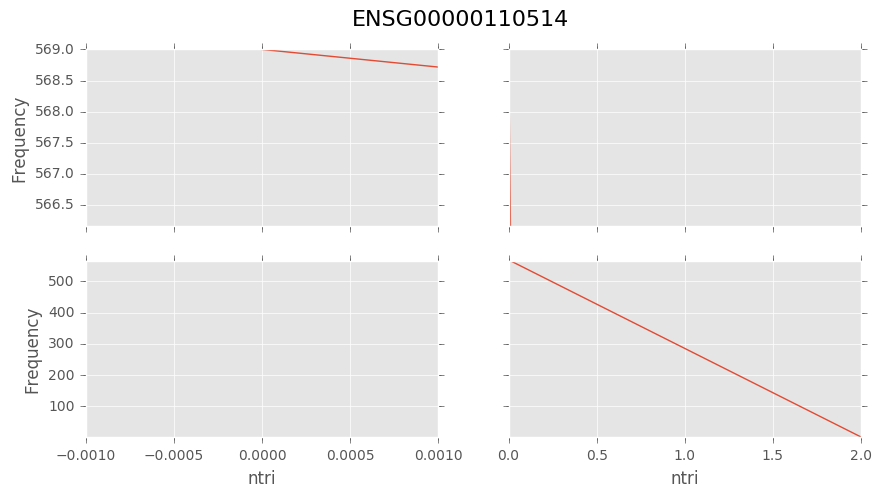

In [207]:
plot_frequencies(gene_min);

/nfs/software/stegle/users/horta/conda-envs/data27/lib/python2.7/site-packages/matplotlib/axes/_base.py:3040: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


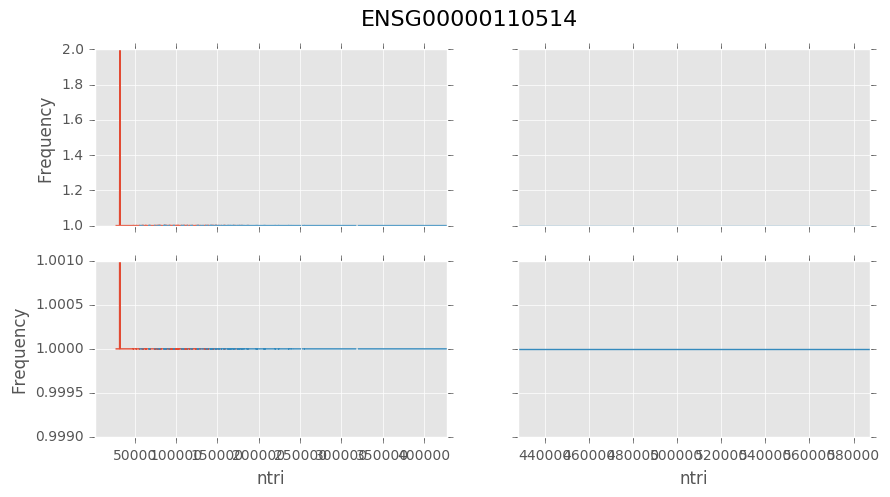

In [208]:
plot_frequencies(gene_max);

Each line of the above figure is a different intron of the corresponding gene.

In [13]:
table = pd.read_hdf('introns_events_3.h5', 'df', where="(gene == '%s') & (intron == %d)" % (gene_id, intron_id))

In [14]:
table.head()

assay  nread0  nread1
gene            intron                                      
ENSG00000110514 1       HG00096.1.M_111124_6       1       2
                1       HG00097.7.M_120219_2       0       3
                1       HG00099.1.M_120209_6       0       4
                1       HG00099.5.M_120131_3       0       3
                1       HG00100.2.M_111215_8       0       2

In [15]:
table.shape

(571, 3)

In [95]:
df0 = pd.DataFrame(dict(nsuccesses=table['nread0'],
                        ntrials=table['nread0'] + table['nread1']))
df1 = pd.concat([df0.groupby('ntrials').count().rename(columns={'nsuccesses':'frequency'}),
      100*df0.groupby('ntrials').mean().rename(columns={'nsuccesses':'%avg. nsuc'})], axis=1)

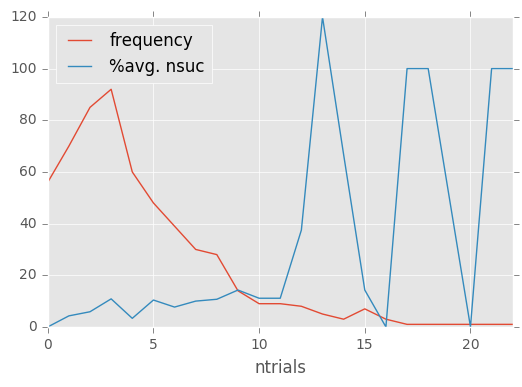

In [96]:
df1.plot()

In [100]:
st.skew(df1['frequency'])

0.9738562378422959

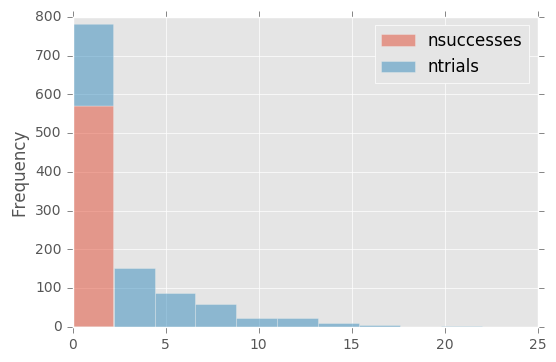

In [52]:
sdf.plot.hist(stacked=True, alpha=0.5, bins=10)

,count
ntrials,
0,56
1,70
2,85
3,92
4,60
5,48
6,39
7,30
8,28


In [42]:
import numpy as np

ratio = table['nread0']/(table['nread0'] + table['nread1'])
ratio -= ratio.mean()
ratio /= ratio.std()
sdf = pd.DataFrame(dict(ratio=ratio))

In [44]:
3/2

1.5

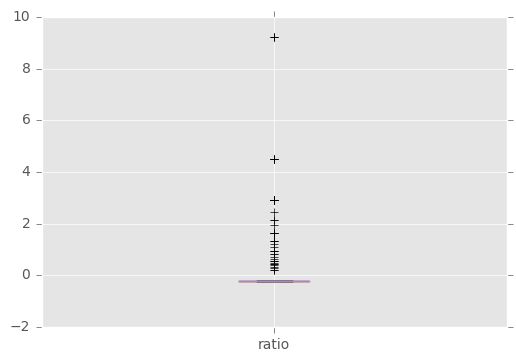

In [43]:
sdf.plot.box();

In [3]:
df.head()

assay  nread0  nread1
gene            intron                                      
ENSG00000000003 1       HG00096.1.M_111124_6       0       2
                2       HG00096.1.M_111124_6       0       1
                3       HG00096.1.M_111124_6       0       0
                4       HG00096.1.M_111124_6       0       2
                5       HG00096.1.M_111124_6       0       3

In [4]:
df.to_hdf('intro_events_1.h5', 'df', mode='w', complib='blosc', format='table')

In [6]:
hdf = pd.HDFStore('intro_events_1.h5', mode='r')

In [8]:
s = hdf.get_storer('df')
s

frame_table  (typ->appendable_multi,nrows->128811890,ncols->5,indexers->[index],dc->[intron,gene])

In [14]:
hdf.close()

In [15]:
hdf = pd.HDFStore('intro_events_1.h5')

In [19]:
gene_set = set(list(hdf.root.df.table.col('gene')))

In [23]:
hdf.put('gene_set', pd.Series(list(gene_set)))

In [24]:
hdf.close()

In [25]:
hdf = pd.HDFStore('intro_events_1.h5')

In [29]:
gs = hdf.get_storer('gene_set')

In [38]:
gene_set = hdf['gene_set']

In [50]:
hdf.put('gene_set', gene_set, encoding='ascii')

In [51]:
hdf.close()

In [52]:
hdf = pd.HDFStore('intro_events_1.h5')

In [58]:
q = hdf.select('df', columns=['gene', 'intron'])

In [74]:
q.head()
df.index.levels[1]

Empty DataFrame
Columns: []
Index: [(ENSG00000000003, 1), (ENSG00000000003, 2), (ENSG00000000003, 3), (ENSG00000000003, 4), (ENSG00000000003, 5)]

In [79]:
q.reset_index()
# q.set_index(['gene'], inplace=True)
# q.set_index(['gene'], inplace=True).sort_index(inplace=True)

,gene,intron
0,ENSG00000000003,1
1,ENSG00000000003,2
2,ENSG00000000003,3
3,ENSG00000000003,4
4,ENSG00000000003,5
5,ENSG00000000003,6
6,ENSG00000000003,7
7,ENSG00000000005,1
8,ENSG00000000005,2
9,ENSG00000000005,3


In [71]:
q.head()

Signature: q.to_dict(orient='dict')
Docstring:
Convert DataFrame to dictionary.

Parameters
----------
orient : str {'dict', 'list', 'series', 'split', 'records', 'index'}
    Determines the type of the values of the dictionary.

    - dict (default) : dict like {column -> {index -> value}}
    - list : dict like {column -> [values]}
    - series : dict like {column -> Series(values)}
    - split : dict like
      {index -> [index], columns -> [columns], data -> [values]}
    - records : list like
      [{column -> value}, ... , {column -> value}]
    - index : dict like {index -> {column -> value}}

      .. versionadded:: 0.17.0

    Abbreviations are allowed. `s` indicates `series` and `sp`
    indicates `split`.

Returns
-------
result : dict like {column -> {index -> value}}
File:      /nfs/software/stegle/users/horta/conda-envs/data27/lib/python2.7/site-packages/pandas/core/frame.py
Type:      instancemethod


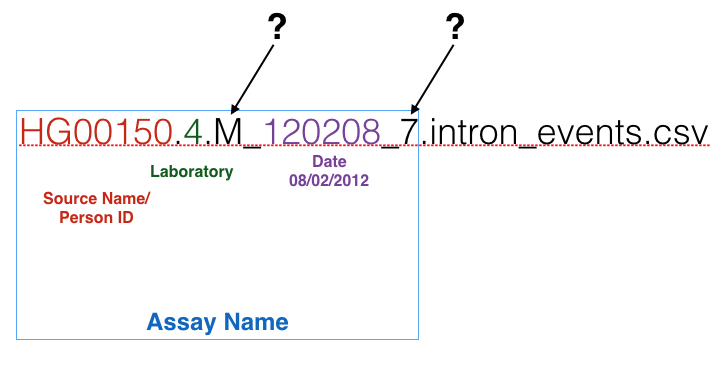

In [1]:
from IPython.display import Image
Image(filename='filename-interpretation.png') 

Filename [counts/convert_csv_to_dataframe.ipynb](counts/convert_csv_to_dataframe.ipynb) was used
to merge and convert the `csv` files into a [bcolz](https://github.com/Blosc/bcolz) dataset
saved at folder **counts/introns.bcolz**.

Filename [[counts/compute_unique_values.ipynb](counts/compute_unique_values.ipynb)] pre-computes the
unique values for *gene*, *assay*, *person_id*, and *lab_id* columns. This is just
for speeding up purposes.

Filename [[counts/create_position_dataset.ipynb](counts/create_position_dataset.ipynb)] creates
a dictionary of start and ending positions for each gene-intron pair.

## How do I use use the dataset?

In [2]:
import sys
assert sys.version_info >= (3, 5)
import bcolz
import numpy as np

ugene = bcolz.open(rootdir='counts/ugene.bcolz')
print("# unique genes: %d" % ugene.shape[0])

uassay = bcolz.open(rootdir='counts/uassay.bcolz')
print("# unique assays: %d" % uassay.shape[0])

ulab_id = bcolz.open(rootdir='counts/ulab_id.bcolz')
print("# unique labs: %d" % ulab_id.shape[0])

uperson_id = bcolz.open(rootdir='counts/uperson_id.bcolz')
print("# unique persons: %d" % uperson_id.shape[0])

# unique genes: 30692
# unique assays: 571
# unique labs: 7
# unique persons: 464


In [3]:
import msgpack
import blosc
from toolz import first

with open('counts/positions.msg.blosc', 'rb') as f:
    positions = msgpack.unpackb(blosc.decompress(f.read()))

gene = first(positions.keys())
intron = first(positions[gene].keys())
start_pos = positions[gene][intron][b'start_pos']
end_post = positions[gene][intron][b'end_pos']

print("Gene %s, intron %s: [%d, %d]" % (gene, intron, start_pos, end_post))
print("Window size: %d" % (end_post - start_pos))

Gene b'ENSG00000013588', intron 1: [13044609, 13061166]
Window size: 16557


In [4]:
data = bcolz.open(rootdir='counts/introns.bcolz')
subdata = data.fetchwhere("(gene == '%s') & (intron == %d)" % (gene.decode(), intron))

In [5]:
subdata.cols.names

['gene', 'intron', 'assay', 'person_id', 'lab_id', 'nsuccesses', 'ntrials']

In [6]:
df = subdata.todataframe()
df

,gene,intron,assay,person_id,lab_id,nsuccesses,ntrials
0,ENSG00000013588,1,HG00273.3.M_120202_7,HG00273,3,0,20
1,ENSG00000013588,1,HG00112.6.M_120119_2,HG00112,6,2,20
2,ENSG00000013588,1,HG00262.2.M_111215_8,HG00262,2,2,35
3,ENSG00000013588,1,NA12004.4.M_120208_5,NA12004,4,0,2
4,ENSG00000013588,1,NA20528.2.M_120131_1,NA20528,2,1,13
5,ENSG00000013588,1,HG00308.3.M_120202_3,HG00308,3,0,4
6,ENSG00000013588,1,NA19095.2.M_120131_2,NA19095,2,0,2
7,ENSG00000013588,1,NA12400.2.M_111216_2,NA12400,2,2,17
8,ENSG00000013588,1,NA19189.5.M_120131_7,NA19189,5,0,17
9,ENSG00000013588,1,NA20804.4.M_120208_1,NA20804,4,0,2


# Copy and paste code

In [1]:
class Dataset(object):
    _root = '/hps/nobackup/stegle/users/horta/dataset/intron/quant_splicing/transcript-qtls/'
    def __init__(self):
        import sys
        import bcolz
        import numpy as np
        import msgpack
        import blosc
        from toolz import first
        from numpy import asarray
    
        self.ugene = asarray(bcolz.open(rootdir=self._path('counts/ugene.bcolz')))
        print("# unique genes: %d" % self.ugene.shape[0])

        self.uassay = asarray(bcolz.open(rootdir=self._path('counts/uassay.bcolz')))
        print("# unique assays: %d" % self.uassay.shape[0])

        self.ulab_id = asarray(bcolz.open(rootdir=self._path('counts/ulab_id.bcolz')))
        print("# unique labs: %d" % self.ulab_id.shape[0])

        self.uperson_id = asarray(bcolz.open(rootdir=self._path('counts/uperson_id.bcolz')))
        print("# unique persons: %d" % self.uperson_id.shape[0])
        
        with open(self._path('counts/positions.msg.blosc'), 'rb') as f:
            self.positions = msgpack.unpackb(blosc.decompress(f.read()))
    
    def _path(self, p):
        from os.path import join
        return join(self._root, p)

    def phenotype(self, gene, intron):
        import bcolz
        intron = int(intron)
        data = bcolz.open(rootdir=self._path('counts/introns.bcolz'))
        return data.fetchwhere("(gene == '%s') & (intron == %d)" % (gene, intron))
    
    def columns(self):
        import bcolz
        return bcolz.open(rootdir=self._path('counts/introns.bcolz')).cols.names
    
    def introns(self, gene):
        gene = gene.encode()
        return list(self.positions[gene].keys())
    
    def window(self, gene, intron):
        intron = int(intron)
        gene = gene.encode()
        return self.positions[gene][intron]

In [2]:
d = Dataset()

# unique genes: 30692
# unique assays: 571
# unique labs: 7
# unique persons: 464


In [3]:
print(d.ugene[0], d.introns('ENSG00000000003'))

ENSG00000000003 [1, 2, 3, 4, 5, 6, 7]


In [4]:
print(d.window(d.ugene[0], 1))

{b'end_pos': 99885745, b'start_pos': 99884994}


In [5]:
print(d.phenotype(d.ugene[0], 1))

KeyboardInterrupt: 

In [2]:
import bcolz
data = bcolz.open(rootdir='counts/introns.bcolz')

In [6]:
df = data.todataframe(['gene', 'intron'], orient='index')

KeyboardInterrupt: 

In [ ]:
# df.set_index()

In [ ]:
df.to_hdf('introns.hdf', 'root', mode='w', complib='blosc', format='table')

In [5]:
data.cols.names

['gene', 'intron', 'assay', 'person_id', 'lab_id', 'nsuccesses', 'ntrials']